# Create protein expression atlas

Copied source code from notebook from Tine Claeys (see folder *"Reference"*)

In [2]:
import pandas as pd
import mysql.connector
import numpy as np

In [12]:
conn = mysql.connector.connect(user='root', password='password', host='127.0.0.1', port='3306',database='expression_atlas_cells')
mycursor = conn.cursor(buffered = True)

# check the connection
if conn.is_connected():
    print("connection succesfull")
else:
    print("no connection")

connection succesfull


In [3]:
assaysql = "SELECT assay_id, peptide_id, quantification FROM peptide_to_assay"
assayData = pd.read_sql_query(assaysql, conn)
assayData.head()

,assay_id,peptide_id,quantification
0,31000,110730450,1.0
1,31002,110730450,3.0
2,31003,110730450,2.0
3,31048,110730450,2.0
4,31049,110730450,2.0


Get all peptide to protein relations

In [4]:
pepsql = "SELECT peptide_to_protein.peptide_id, peptide_to_protein.uniprot_id FROM peptide_to_protein"
pepData = pd.read_sql_query(pepsql, conn)
pepData.head()

,peptide_id,uniprot_id
0,110745848,A0A024RBG1
1,112000279,A0A024RBG1
2,112950201,A0A075B6I1
3,115802737,A0A075B6R2
4,113028442,A0A075B6R9


Get sequence length for all proteins in the database

In [5]:
seqsql = "SELECT uniprot_id, length FROM protein WHERE length IS NOT NULL"
seqData = pd.read_sql_query(seqsql, conn)
seqData["length"] = pd.to_numeric(seqData['length'], errors = "coerce")
seqData.head()

,uniprot_id,length
0,A0A024RBG1,181.0
1,A0A075B6I1,120.0
2,A0A075B6R2,117.0
3,A0A075B6R9,120.0
4,A0A075B6V5,113.0


Select proteotypic peptides (peptide with 1 peptide to protein relation)

In [6]:
proteotypicData = pepData.groupby("peptide_id").filter(lambda x: len(x) == 1)
proteotypicData

,peptide_id,uniprot_id
0,110745848,A0A024RBG1
1,112000279,A0A024RBG1
2,112950201,A0A075B6I1
3,115802737,A0A075B6R2
4,113028442,A0A075B6R9
...,...,...
166146,114608972,TRYP_PIG
166147,115899381,TRYP_PIG
166148,113696016,W5XKT8
166149,113952018,W5XKT8


Select proteins which have more than 2 proteotypic peptides

In [7]:
proteins = proteotypicData.groupby("uniprot_id").filter(lambda x: len(x) > 2)
proteins.shape

(160630, 2)

Drop non human proteins

In [8]:
non_human_proteins = non_human = """ADH1_YEAST,,,
ALBU_BOVIN,,,
ALDOA_RABIT,,,
BGAL_ECOLI,,,
CAH2_BOVIN,,,
CAS1_BOVIN,,,
CAS2_BOVIN,,,
CASB_BOVIN,,,
CASK_BOVIN,,,
CYC_HORSE,,,
DHE3_BOVIN,,,
GAG_SCVLA,,,
GFP_AEQVI,,,
K1C15_SHEEP,,,
K1M1_SHEEP,,,
K1M2_SHEEP,,,
K2M1_SHEEP,,,
K2M2_SHEEP,,,
K2M3_SHEEP,,,
KRA3_SHEEP,,,
KRA61_SHEEP,,,
LALBA_BOVIN,,,
LYSC_CHICK,,,
LYSC_LYSEN,,,
MYG_HORSE,,,
REF_HEVBR,,,
SRPP_HEVBR,,,
TRY1_BOVIN,,,
TRYP_PIG""".split(",,,\n")
proteins = proteins[~proteins["uniprot_id"].isin(non_human_proteins)]

Merge assays containing spectral counts and proteins

In [9]:
protData = pd.merge(assayData, proteins, on = "peptide_id").sort_values(["assay_id", "uniprot_id"])
del protData['peptide_id']
protData.head(10)

,assay_id,quantification,uniprot_id
798205,30960,1.0,A0A1B0GUS4
814115,30960,2.0,A0AVT1
1652862,30960,3.0,A0AVT1
1682397,30960,2.0,A0MZ66
1892092,30960,1.0,A1L170
1666304,30960,2.0,A2RRP1
1890305,30960,1.0,A2RUC4
1890382,30960,1.0,A3KMH1
1668130,30960,2.0,A4D1E9
1842264,30960,3.0,A6NCS6


Split data per assay

In [10]:
assays = protData['assay_id'].unique()
DataFramaDict = {elem: pd.DataFrame for elem in assays}
for key in DataFramaDict.keys():
    DataFramaDict[key] = protData[:][protData["assay_id"] ==  key]

DataFramaDict2 = DataFramaDict.copy()

Calculate NSAF score for each protein per assay

In [11]:
for count, key in enumerate(DataFramaDict2.keys()):
    sumSaf = 0
    assay = DataFramaDict2[key]
    assay.pop("assay_id")

    #calculate sum of spectral counts for each protein
    grouped = DataFramaDict2[key].groupby("uniprot_id").sum().reset_index()
    seqAddedDF = pd.merge(grouped, seqData, on = "uniprot_id")
    seqAddedDF.insert(loc = 2, column = 'SAF', value = 0)
    seqAddedDF.insert(loc = 3, column = 'NSAF', value = 0)
    
    #Calculate SAF score for each protein by dividing sum of spectral counts by protein length
    for index, row in seqAddedDF.iterrows():
        saf = row['quantification']/row['length']
        seqAddedDF.loc[index, 'SAF'] = saf
        # calculate sum of SAF scores in assay
        sumSaf += saf

    # Calculate NSAF score by normalizing each SAF score
    seqAddedDF["NSAF"] = seqAddedDF["SAF"] / sumSaf
    
    del seqAddedDF['length']
    del seqAddedDF['quantification']
    del seqAddedDF['SAF']
    seqAddedDF.insert(loc = 0, column = 'assay_id', value = key)
    DataFramaDict2[key] = seqAddedDF


In [12]:
proteinData = pd.DataFrame()

for key in DataFramaDict2.keys():
    proteinData = proteinData.append(DataFramaDict2[key])

In [13]:
proteinData.head()

,assay_id,uniprot_id,NSAF
0,30960,A0A1B0GUS4,0.000802
1,30960,A0AVT1,0.000587
2,30960,A0MZ66,0.000391
3,30960,A1L170,0.000454
4,30960,A2RRP1,0.000104


In [18]:
len(proteinData.assay_id.unique())

859

In [14]:
#write NSAF proteome to file
proteinData.to_csv(path_or_buf = 'proteome_nsaf_1.csv', index = False)
df = pd.read_csv('proteome_nsaf_1.csv')
df.head()

,assay_id,uniprot_id,NSAF
0,30960,A0A1B0GUS4,0.000802
1,30960,A0AVT1,0.000587
2,30960,A0MZ66,0.000391
3,30960,A1L170,0.000454
4,30960,A2RRP1,0.000104


## Create the NSAF atlas, a minmax version of the NSAF atlas, a heatmap and the proteinCount per tissue file

In [16]:
df = pd.read_csv("proteome_nsaf_1.csv")

assay_project_query = "SELECT assay_id, project_id FROM assay"
assay_project_data = pd.read_sql_query(assay_project_query, conn)

assay_cell_query = "SELECT assay_id, cell_id FROM cell_to_assay"
assay_cell_data = pd.read_sql_query(assay_cell_query, conn)

cell_query = "SELECT cell_id, cell_line, disease FROM cell"
cell_data = pd.read_sql_query(cell_query, conn)

full_df = pd.merge(df, assay_project_data, on = "assay_id")
print(full_df.loc[full_df.project_id == 1791])
full_df = pd.merge(full_df, assay_cell_data, on = "assay_id")
full_df = pd.merge(full_df, cell_data, on = "cell_id")

cell_lines = full_df.cell_line
projects = full_df.project_id

full_df

Empty DataFrame
Columns: [assay_id, uniprot_id, NSAF, project_id]
Index: []


,assay_id,uniprot_id,NSAF,project_id,cell_id,cell_line,disease
0,30960,A0A1B0GUS4,0.000802,1815,545,Hep3B,hepatocellular carcinoma
1,30960,A0AVT1,0.000587,1815,545,Hep3B,hepatocellular carcinoma
2,30960,A0MZ66,0.000391,1815,545,Hep3B,hepatocellular carcinoma
3,30960,A1L170,0.000454,1815,545,Hep3B,hepatocellular carcinoma
4,30960,A2RRP1,0.000104,1815,545,Hep3B,hepatocellular carcinoma
...,...,...,...,...,...,...,...
1047531,32910,Q9Y6W5,0.000276,1862,604,THP1,monocytic leukemia
1047532,32910,Q9Y6X3,0.000140,1862,604,THP1,monocytic leukemia
1047533,32910,Q9Y6X5,0.000038,1862,604,THP1,monocytic leukemia
1047534,32910,Q9Y6X9,0.000017,1862,604,THP1,monocytic leukemia


In [17]:
list(full_df.cell_line.unique())

['Hep3B',
 'MHCC97',
 'Jurkat',
 'LAN5',
 'A431',
 'HEK293',
 'MCF7',
 'ZR751',
 'JVM13',
 'HUVEC',
 'SKBR3',
 'HeLa',
 'Huh7',
 'HCT116',
 'K562',
 'U87',
 'A549',
 'PC3',
 'HepG2',
 'KO52',
 'HL60',
 'BeWo',
 'HTR8',
 'SHSY5Y',
 'MDA-MB-231',
 'SKNBE2',
 'A2780',
 'HT29',
 'THP1']

In [18]:
NSAF_data_table = pd.pivot_table(full_df, values = 'NSAF', index = 'uniprot_id', columns = 'cell_line').fillna(0)
NSAF_data_table

cell_line,A2780,A431,A549,BeWo,HCT116,HEK293,HL60,HT29,HTR8,HUVEC,...,MCF7,MDA-MB-231,MHCC97,PC3,SHSY5Y,SKBR3,SKNBE2,THP1,U87,ZR751
uniprot_id,,,,,,,,,,,,,,,,,,,,,
A0A1B0GTU1,0.000000,0.000000,0.000025,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000055,0.000000,0.0,0.000000,0.000000,0.000019,0.000000
A0A1B0GUS4,0.000513,0.000428,0.000000,0.0,0.000000,0.000704,0.000000,0.000222,0.0,0.000626,...,0.000347,0.000000,0.001684,0.000000,0.000663,0.0,0.000000,0.000147,0.000358,0.000395
A0AV02,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000105
A0AV96,0.000000,0.000000,0.000170,0.0,0.000064,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000121,0.000000,0.000000,0.000057,0.000000,0.0,0.000000,0.000000,0.000052,0.000000
A0AVF1,0.000000,0.000000,0.000000,0.0,0.000056,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000032,0.000000,0.000000,0.000104,0.000000,0.0,0.000000,0.000000,0.000064,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6X8,0.000000,0.000000,0.000045,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000058,...,0.000091,0.000000,0.000152,0.000000,0.000000,0.0,0.000020,0.000000,0.000041,0.000000
Q9Y6X9,0.000000,0.000000,0.000034,0.0,0.000041,0.000213,0.001719,0.000120,0.0,0.000000,...,0.000118,0.000101,0.000192,0.000048,0.000089,0.0,0.000132,0.000023,0.000027,0.000107
Q9Y6Y0,0.000000,0.000000,0.000000,0.0,0.000000,0.000299,0.001094,0.000050,0.0,0.000115,...,0.000140,0.000000,0.000326,0.000000,0.000161,0.0,0.000107,0.000072,0.000170,0.000101


In [19]:
#minmax scaling so values lie between 0 and 1
minmax_atlas = (NSAF_data_table - NSAF_data_table.min()) / (NSAF_data_table.max() - NSAF_data_table.min())
minmax_atlas

cell_line,A2780,A431,A549,BeWo,HCT116,HEK293,HL60,HT29,HTR8,HUVEC,...,MCF7,MDA-MB-231,MHCC97,PC3,SHSY5Y,SKBR3,SKNBE2,THP1,U87,ZR751
uniprot_id,,,,,,,,,,,,,,,,,,,,,
A0A1B0GTU1,0.000000,0.000000,0.001096,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.009548,0.000000,0.0,0.000000,0.000000,0.001299,0.000000
A0A1B0GUS4,0.018222,0.029581,0.000000,0.0,0.000000,0.003655,0.000000,0.002299,0.0,0.032485,...,0.010885,0.000000,0.085696,0.000000,0.047061,0.0,0.000000,0.010732,0.024481,0.019425
A0AV02,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.005180
A0AV96,0.000000,0.000000,0.007520,0.0,0.006226,0.000000,0.000000,0.000000,0.0,0.000000,...,0.003797,0.000000,0.000000,0.009818,0.000000,0.0,0.000000,0.000000,0.003526,0.000000
A0AVF1,0.000000,0.000000,0.000000,0.0,0.005405,0.000000,0.000000,0.000000,0.0,0.000000,...,0.001003,0.000000,0.000000,0.017990,0.000000,0.0,0.000000,0.000000,0.004383,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6X8,0.000000,0.000000,0.001986,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.002987,...,0.002845,0.000000,0.007747,0.000000,0.000000,0.0,0.000527,0.000000,0.002776,0.000000
Q9Y6X9,0.000000,0.000000,0.001505,0.0,0.003917,0.001107,0.029406,0.001242,0.0,0.000000,...,0.003713,0.002937,0.009748,0.008391,0.006315,0.0,0.003527,0.001651,0.001812,0.005248
Q9Y6Y0,0.000000,0.000000,0.000000,0.0,0.000000,0.001552,0.018717,0.000515,0.0,0.005959,...,0.004400,0.000000,0.016579,0.000000,0.011431,0.0,0.002857,0.005269,0.011651,0.004943


In [20]:
cols = minmax_atlas.columns
minmax_atlas[cols] = minmax_atlas[cols].apply(pd.to_numeric, errors='coerce')
minmax_atlas.idxmax()

cell_line
A2780         P62805
A431          P30041
A549          P05783
BeWo          P31949
HCT116        P62805
HEK293        P62805
HL60          P62805
HT29          P62805
HTR8          P63313
HUVEC         P09382
HeLa          P62805
Hep3B         P62857
HepG2         P10809
Huh7          P04406
JVM13         P10809
Jurkat        P63313
K562          P06733
KO52          O95059
LAN5          P62805
MCF7          P62805
MDA-MB-231    P62805
MHCC97        P10599
PC3           P63220
SHSY5Y        Q562R1
SKBR3         P62805
SKNBE2        P62805
THP1          P62805
U87           P09382
ZR751         P62805
dtype: object

Remark: P62805 is most prevalent in most cell lines. P62805 is the H4 histon protein

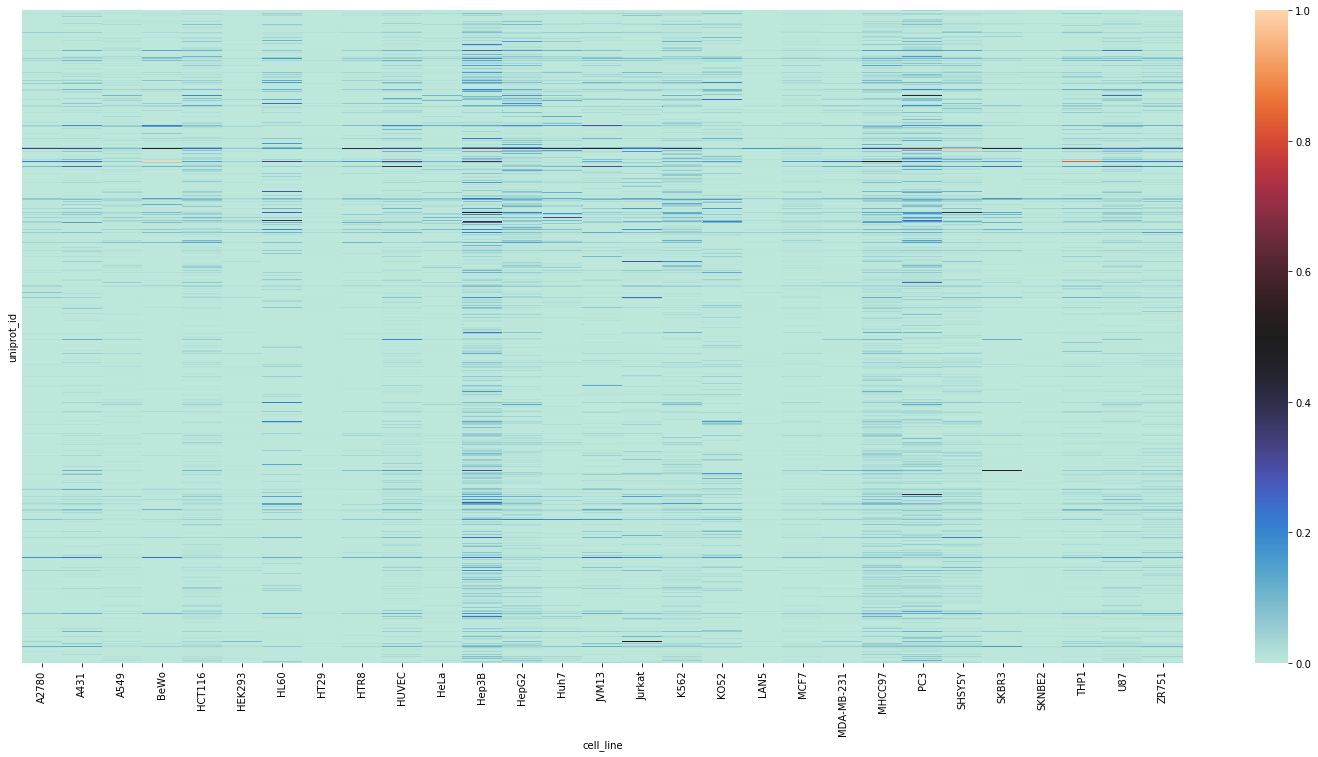

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
fig, ax = plt.subplots(figsize=(26,12))
datamap = sns.heatmap(minmax_atlas, ax=ax, yticklabels = False,cmap='icefire')
#datamap.figure.savefig('heatmap_expressionpurple0806.png')
datamap

In [22]:
# split dataset per cell
tissues = full_df['cell_line'].unique()
DataFrameDict3 = {elem : pd.DataFrame for elem in tissues}
for key in DataFrameDict3.keys():
    DataFrameDict3[key] = full_df[:][full_df['cell_line'] == key]

In [23]:
# count number of proteins for each cell
proteinCount = {}

for key in DataFrameDict3.keys():
    cell_line = DataFrameDict3[key].pop('cell_line')
    grouped = DataFrameDict3[key].groupby('uniprot_id').mean().reset_index()
    count = len(grouped.index)
    proteinCount[key] = str(count)

In [24]:

for key, val in proteinCount.items():
    print(key + ": " + val)

Hep3B: 4858
MHCC97: 5687
Jurkat: 4342
LAN5: 2194
A431: 2496
HEK293: 4083
MCF7: 6824
ZR751: 4064
JVM13: 2897
HUVEC: 4456
SKBR3: 1070
HeLa: 3265
Huh7: 2435
HCT116: 5600
K562: 5525
U87: 6086
A549: 5833
PC3: 5759
HepG2: 5395
KO52: 2533
HL60: 1625
BeWo: 1013
HTR8: 1034
SHSY5Y: 4774
MDA-MB-231: 1825
SKNBE2: 5687
A2780: 1960
HT29: 2660
THP1: 4574


## Preparing data for t-SNE analysis

In [25]:
query = "SELECT assay_id, cell_id FROM cell_to_assay"
query2 = "SELECT cell_id, cell_line, tissue_type FROM cell"
query3 = "SELECT assay_id, project_id FROM assay"
cell_assay = pd.read_sql_query(query, conn)
cell = pd.read_sql_query(query2, conn)
project = pd.read_sql_query(query3, conn)
grouped = pd.merge(cell_assay, cell, on = "cell_id")
grouped = pd.merge(grouped, project, on = "assay_id")
grouped

,assay_id,cell_id,cell_line,tissue_type,project_id
0,30960,545,Hep3B,liver,1815
1,30961,545,Hep3B,liver,1815
2,30962,545,Hep3B,liver,1815
3,30963,545,Hep3B,liver,1815
4,30964,545,Hep3B,liver,1815
...,...,...,...,...,...
2214,33108,610,LnCap,prostate,1865
2215,33109,610,LnCap,prostate,1865
2216,33110,610,LnCap,prostate,1865
2217,33111,610,LnCap,prostate,1865


In [26]:
assay_atlas = pd.pivot_table(full_df, values = 'NSAF', index = 'assay_id', columns = 'uniprot_id').fillna(0).reset_index()
assay_atlas

uniprot_id,assay_id,A0A1B0GTU1,A0A1B0GUS4,A0AV02,A0AV96,A0AVF1,A0AVK6,A0AVT1,A0FGR8,A0JLT2,...,Q9Y6W3,Q9Y6W5,Q9Y6X3,Q9Y6X4,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y1,Q9Y6Y8
0,30960,0.0,0.000802,0.0,0.0,0.0,0.00000,0.000587,0.0,0.0,...,0.000304,0.000000,0.000000,0.0,0.000000,0.000000,0.000120,0.000000,0.0,0.000000
1,30961,0.0,0.000748,0.0,0.0,0.0,0.00000,0.000766,0.0,0.0,...,0.000425,0.000000,0.000000,0.0,0.000000,0.000000,0.000112,0.000000,0.0,0.000115
2,30962,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000374,0.0,0.0,...,0.000323,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,30963,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000910,0.0,0.0,...,0.000000,0.000480,0.000000,0.0,0.000000,0.000000,0.000116,0.000000,0.0,0.000000
4,30964,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000811,0.0,0.0,...,0.000000,0.000490,0.000000,0.0,0.000000,0.000291,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
854,32907,0.0,0.000111,0.0,0.0,0.0,0.00000,0.000456,0.0,0.0,...,0.000021,0.000275,0.000028,0.0,0.000038,0.000000,0.000017,0.000107,0.0,0.000274
855,32908,0.0,0.000111,0.0,0.0,0.0,0.00000,0.000489,0.0,0.0,...,0.000105,0.000310,0.000112,0.0,0.000038,0.000000,0.000033,0.000000,0.0,0.000223
856,32909,0.0,0.000114,0.0,0.0,0.0,0.00002,0.000518,0.0,0.0,...,0.000022,0.000318,0.000086,0.0,0.000000,0.000000,0.000034,0.000000,0.0,0.000281
857,32910,0.0,0.000223,0.0,0.0,0.0,0.00000,0.000523,0.0,0.0,...,0.000021,0.000276,0.000140,0.0,0.000038,0.000000,0.000017,0.000000,0.0,0.000172


In [27]:
atlas = pd.merge(assay_atlas, grouped, on = 'assay_id')
atlas = atlas.drop(['assay_id', 'cell_id'], axis=1)
atlas

,A0A1B0GTU1,A0A1B0GUS4,A0AV02,A0AV96,A0AVF1,A0AVK6,A0AVT1,A0FGR8,A0JLT2,A0JNW5,...,Q9Y6X4,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y1,Q9Y6Y8,cell_line,tissue_type,project_id
0,0.0,0.000802,0.0,0.0,0.0,0.00000,0.000587,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000120,0.000000,0.0,0.000000,Hep3B,liver,1815
1,0.0,0.000748,0.0,0.0,0.0,0.00000,0.000766,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000112,0.000000,0.0,0.000115,Hep3B,liver,1815
2,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000374,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,Hep3B,liver,1815
3,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000910,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000116,0.000000,0.0,0.000000,Hep3B,liver,1815
4,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000811,0.0,0.0,0.000000,...,0.0,0.000000,0.000291,0.000000,0.000000,0.0,0.000000,Hep3B,liver,1815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
854,0.0,0.000111,0.0,0.0,0.0,0.00000,0.000456,0.0,0.0,0.000012,...,0.0,0.000038,0.000000,0.000017,0.000107,0.0,0.000274,THP1,blood,1862
855,0.0,0.000111,0.0,0.0,0.0,0.00000,0.000489,0.0,0.0,0.000000,...,0.0,0.000038,0.000000,0.000033,0.000000,0.0,0.000223,THP1,blood,1862
856,0.0,0.000114,0.0,0.0,0.0,0.00002,0.000518,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000034,0.000000,0.0,0.000281,THP1,blood,1862
857,0.0,0.000223,0.0,0.0,0.0,0.00000,0.000523,0.0,0.0,0.000000,...,0.0,0.000038,0.000000,0.000017,0.000000,0.0,0.000172,THP1,blood,1862


In [28]:
atlas.to_csv('tsne_atlas.csv', index=False)